<a href="https://colab.research.google.com/github/theKirill/RecognitionOfRoadSigns/blob/master/CourseWork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os

In [0]:
import numpy as np

In [0]:
from skimage import io, transform

In [0]:
import matplotlib.pyplot as plt

In [0]:
import pandas as pd

In [0]:
from PIL import Image, ImageDraw

In [0]:
import cv2

In [0]:
import keras 

In [0]:
from keras.models import Sequential 

In [0]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [0]:
from keras.utils import to_categorical

In [0]:
from keras.callbacks import ModelCheckpoint

In [0]:
from keras.models import load_model

In [0]:
from sklearn import model_selection   

In [0]:
#from sklearn.model_selection import cross_val_score

In [0]:
from sklearn.utils import shuffle 

In [0]:
import seaborn as sn
from sklearn.metrics import classification_report

In [0]:
from sklearn.metrics.pairwise import cosine_similarity

In [0]:
from skimage import exposure, feature, transform

In [0]:
import matplotlib.patches as patches

In [0]:
import heapq

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
from keras.utils import plot_model

In [0]:
import keras_metrics

ModuleNotFoundError: ignored

In [0]:
!pip install keras_metrics

In [0]:
from sklearn.utils import check_random_state

In [0]:
IMG_SIZE = 32 #размер изображения

In [0]:
CLASSES_COUNT = 30

In [0]:
class RoadSignLocalization:
  def __init__(self, train_images_path = "drive/My Drive/Images_Train/", test_images_path = "drive/My Drive/Images_Test/", extension = ".ppm"):
    self.__train_images_path = train_images_path #путь с тренировочными изображениями
    self.__test_images_path = test_images_path #путь с тестовыми изображениями
    self.__train_test_images_extension = extension #расширения тренировочных и тестовых изображений

  # Получение всех содержащихся обучающих изображений знаков и номеров классов этих знаков, с предобработкой
  def get_all_train_images(self, classes_to_categorical = False):
    images_of_signs = []
    classes_of_signs = []

    for root, dirs, files in os.walk(self.__train_images_path):
      sign_class = root[-2:]

      if sign_class.isdigit():#у каждого класса знака читаем csv-файл
        name_csv = root + "/GT-000" + sign_class + ".csv"
        file_csv = pd.read_csv(name_csv, delimiter = ';')
        #Берём углы знаков для каждого изображения из csv файла
        x_left = file_csv['Roi.X1']
        y_left = file_csv['Roi.Y1']
        x_right = file_csv['Roi.X2']
        y_right = file_csv['Roi.Y2']
        
        i = 0
        for file in files: #каждое изображение обрезаем по области знака, масштабируем до 32*32
          if file[-4:] == self.__train_test_images_extension:
            self.get_sign_area(root +'/', file, y_left[i], y_right[i], x_left[i], x_right[i])
            self.scale_img(root + '/', file[:-4] + "_new" + self.__train_test_images_extension)
            images_of_signs.append(io.imread(root + '/' + file[:-4] + "_new" + self.__train_test_images_extension))#добавляем в массив изображений
            classes_of_signs.append(int(sign_class))#заносим информацию о классе знака
            i+=1
    
    images_of_signs = np.array(images_of_signs, dtype = "float32") / 255.0 #выполняем масштабирование входных значений (нормализуем значения пикселей от 0 до 1)
    
    if classes_to_categorical:
      classes_of_signs = to_categorical(classes_of_signs, CLASSES_COUNT) #преобразование вектора целых чисел (классов) в двоичную матрицу

    return images_of_signs, classes_of_signs

  # Получение всех содержащихся обучающих изображений (уже предобработанных) знаков и номеров классов этих знаков
  def get_all_train_images_without_preprocessing(self, classes_to_categorical = False):
    images_of_signs = []
    classes_of_signs = []

    for root, dirs, files in os.walk(self.__train_images_path):
      sign_class = root[-2:]

      if sign_class.isdigit():
        print(sign_class)
        for file in files:
          if file[-8:] == "_new" + self.__train_test_images_extension:
            images_of_signs.append(io.imread(root + '/' + file))#добавляем в массив изображений
            classes_of_signs.append(int(sign_class))#заносим информацию о классе знака
    
    images_of_signs = np.array(images_of_signs, dtype = "float32") / 255.0 #выполняем масштабирование входных значений (нормализуем значения пикселей от 0 до 1)
    
    if classes_to_categorical:
      classes_of_signs = to_categorical(classes_of_signs, CLASSES_COUNT) #преобразование вектора целых чисел (классов) в двоичную матрицу

    return images_of_signs, classes_of_signs

  # Получение всех тестовых изображений знаков и номеров классов этих знаков
  def get_all_test_images(self, classes_to_categorical = False):
    images_of_signs = []
    classes_of_signs = []

    file_csv = pd.read_csv(self.__test_images_path + 'GT-final_test.csv', delimiter=';') #читаем информацию о каждом изображении
    #Берём углы и классы знаков для каждого изображения из csv файла
    images_names = file_csv['Filename']
    x_left = file_csv['Roi.X1']
    y_left = file_csv['Roi.Y1']
    x_right = file_csv['Roi.X2']
    y_right = file_csv['Roi.Y2']
    classes_of_signs = file_csv["ClassId"]

    for i in range(images_names.size):#каждое изображение обрезаем по области знака, масштабируем до 32*32
      self.get_sign_area(self.__test_images_path, images_names[i], y_left[i], y_right[i], x_left[i], x_right[i])
      self.scale_img(self.__test_images_path, images_names[i][:-4] + "_new" + self.__train_test_images_extension)
      images_of_signs.append(io.imread(self.__test_images_path + images_names[i][:-4] + "_new" + self.__train_test_images_extension))

    images_of_signs = np.array(images_of_signs, dtype = "float32") / 255.0

    if classes_to_categorical:
      classes_of_signs = to_categorical(classes_of_signs, CLASSES_COUNT)

    return images_of_signs, classes_of_signs

  # Получение всех тестовых изображений знаков и номеров классов этих знаков
  def get_all_test_images_without_preprocessing(self, classes_to_categorical = False):
    images_of_signs = []
    classes_of_signs = []

    file_csv = pd.read_csv(self.__test_images_path + 'GT-final_test.csv', delimiter=';') #читаем информацию о каждом изображении
    classes_of_signs = file_csv["ClassId"]
    images_names = file_csv['Filename']

    for i in range(images_names.size):#каждое изображение обрезаем по области знака, масштабируем до 32*32
      images_of_signs.append(io.imread(self.__test_images_path + images_names[i][:-4] + "_new" + self.__train_test_images_extension))

    images_of_signs = np.array(images_of_signs, dtype = "float32") / 255.0

    if classes_to_categorical:
      classes_of_signs = to_categorical(classes_of_signs, CLASSES_COUNT)

    return images_of_signs, classes_of_signs

  # Получение всех изображений знаков для предсказания классов на изображениях пользователя
  def get_all_signs_for_predict(self, images_path = "drive/My Drive/BadSigns/", new_path = "drive/My Drive/GoodSigns/"):
    all_images_of_signs = [] #все знаки каждого изображения (список списков)
    current_image_signs = [] #все знаки конкретного изображения
    all_rects_of_signs = [] #все координаты знаков каждого изображения
    current_image_sign_rect = [] #координаты (x, y, w, h) каждого знака конкретного изображения
    images_names = []

    for root, dirs, files in os.walk(images_path):
      for file in files:
        for i in range(2):
          if (i == 0):
            images_names.append(file)
            current_image_signs = np.array(current_image_signs, dtype = "float32") / 255.0 
            all_images_of_signs.append(current_image_signs)
            all_rects_of_signs.append(current_image_sign_rect)
            current_image_sign_rect = []
            current_image_signs = []

          img = io.imread(root + file)
          hsv = self.to_hsv(img)

          if i == 0:
            mask = self.binarization_red(hsv)
          else:
            mask = self.binarization_blue(hsv)

          mask = self.canny(mask)

          contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #находим контуры

          if len(contours) > 0:
            contours = sorted(contours, key = cv2.contourArea, reverse = True)#сортируем контуры по площади

            contour_ind = 0
            (x,y,w,h) = cv2.boundingRect(contours[contour_ind]) #вырезаем прямоугольную область самого большого контура, получаем координаты его верхнего левого угла и ширину/высоту

            while (w > 70 and h > 70 and contour_ind < len(contours)):
               # обрезаем знак по прямоугольнику, масштабируем
              self.get_sign_area(root, file, y, y + h, x, x + w, new_path)      
              self.scale_img(new_path, file)

              current_image_signs.append(io.imread(new_path + file))
              current_image_sign_rect.append([x,y,w,h])

              contour_ind += 1

              if contour_ind < len(contours):
                (x,y,w,h) = cv2.boundingRect(contours[contour_ind]) #вырезаем прямоугольную область самого большого контура, получаем координаты его верхнего левого угла и ширину/высоту

    current_image_signs = np.array(current_image_signs, dtype = "float32") / 255.0 
    all_images_of_signs.append(current_image_signs)
    all_rects_of_signs.append(current_image_sign_rect)
    images_names = np.array(images_names)

    return all_images_of_signs, all_rects_of_signs, images_names

  #"Вырезание" области знака
  def get_sign_area(self, root, name_img, y_left, y_right, x_left, x_right, new_root = ""):
    img = cv2.imread(root + name_img)
    # Обрезаем изображение по прямоугольнику
    area_sign = img[y_left:y_right, x_left:x_right]

    if new_root == "":
      cv2.imwrite(root + name_img[:-4] + "_new." + name_img[-3:], area_sign)
    else:
      cv2.imwrite(new_root + name_img, area_sign)

  #Масштабирование изображения до 32*32, сохранение получившегося изображения
  def scale_img(self, root, name_img):
    basewidth = 300
    img = Image.open(root + name_img)

    draw = ImageDraw.Draw(img)  # Создаем инструмент для рисования.
    width = img.size[0]  # Определяем ширину.
    height = img.size[1]  # Определяем высоту.
    pix = img.load()  # Выгружаем значения пикселей.

    wpercent = (basewidth / float(img.size[0]))
    # Масштабируем до нужного размера
    img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
    img.save(root + name_img)

  #Перевод изображения в HSV-формат
  def to_hsv(self, img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

  #Поиск с помощью детектора Canny краёв объектов
  def canny(self, img):
    return cv2.Canny(img, 100, 200, apertureSize = 7)
  
  #Бинаризация изображения по красному цвету
  def binarization_red(self, img):
    return cv2.inRange(img, (117, 100, 45), (255, 255, 255))
  
  #Бинаризация изображения по синему цвету
  def binarization_blue(self, img):
    return cv2.inRange(img, (0, 174, 40), (25, 255, 255))#cv2.inRange(img, (117,100,45), (255,255,255))#cv2.inRange(sss, (0, 225, 0), (50, 255, 255))

In [0]:
localization = RoadSignLocalization()

In [0]:
X_train, y_train = localization.get_all_train_images_without_preprocessing()

00
28
23
01
14
02
03
10
04
05
09
06
13
08
07
29
27
26
25
24
12
11
15
16
17
18
19
21
22
20


In [0]:
X_test, y_test = localization.get_all_test_images_without_preprocessing()

In [0]:
all_images, rects, images_names = localization.get_all_signs_for_predict()

In [0]:
class RoadSignClassification:
  def __init__(self):
    self.__EPOCHS_COUNT = 50
    self.__BATCH_SIZE = 200
    self.__KERNEL = (3, 3)
    self.__cnn_model = None
    self.__history = []
    self.__names_classes = ['Ограничение скорости (20)','Ограничение скорости (30)','Ограничение скорости (50)',
                 'Ограничение скорости (60)','Ограничение скорости (70)','Ограничение скорости (80)',
                 'Ограничение скорости (100)','Ограничение скорости (120)','Обгон запрещён',
                 'Главная дорога','Уступите дорогу','STOP','Движение запрещено','Въезд запрещён',
                 'Крутой поворот налево','Крутой поворот направо','Опасные повороты','Неровная дорога',
                 'Скользкая дорога','Сужение дороги справа','Ремонт дороги','Прочие опасности','Осторожно, пешеходы',
                 'Отмена всех ограничений','Поворот только направо','Поворот только налево','Движение только прямо',
                 'Движение прямо и направо','Движение прямо и налево','Круговое движение']

  @property
  def EPOCHS_COUNT(self):
    return self.__EPOCHS_COUNT

  @EPOCHS_COUNT.setter
  def EPOCHS_COUNT(self, count):
    if (count > 0):
      self.__EPOCHS_COUNT = count

  @property
  def BATCH_SIZE(self):
    return self.__BATCH_SIZE

  @BATCH_SIZE.setter
  def BATCH_SIZE(self, size):
    if (size > 0):
      self.__BATCH_SIZE = size

  # Создание модели
  def __get_cnn_model(self):
    model = Sequential() 
    model.add(Conv2D(32, self.__KERNEL, input_shape = (IMG_SIZE, IMG_SIZE, 3), padding = 'same', activation = 'relu'))
    
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, self.__KERNEL, padding = 'same', activation = 'relu'))

    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(128, self.__KERNEL, padding = 'same', activation = 'relu'))

    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Flatten())

    model.add(Dense(1024, activation = 'relu'))
    model.add(Dropout(0.5))

    model.add(Dense(CLASSES_COUNT, activation = 'softmax'))

    model.compile(loss = 'categorical_crossentropy', optimizer = 'nadam', metrics = [keras_metrics.categorical_f1_score()])

    plot_model(model, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)
  
    return model

  #Обучение CNN модели
  def fit_cnn_model(self, X_train, y_train, retrain = False):
    if int(retrain) == 0:
      self.__cnn_model = None
      self.__cnn_model = self.__get_cnn_model()

    self.__history = self.__cnn_model.fit(X_train, y_train, epochs = self.__EPOCHS_COUNT, batch_size = self.__BATCH_SIZE, validation_split = 0.2,
         callbacks = [ModelCheckpoint('drive/My Drive/Models/model.h5', save_best_only = True)]) 
    
    return self.__history

  #Построение графика точности при обучении и валидации
  def graphic_acc(self, metric, w = 25, h = 10):
    x = range(self.__EPOCHS_COUNT)
    plt.figure(figsize = (w, h))
    plt.grid(True)

    plt.plot(x, 
            self.__history.history[metric], 
            'bo-', 
            label = 'Train ' + __EPOCHS_COUNT)
    
    plt.plot(x, 
            self.__history.history['val_' + metric],
            'ro-',
            label = 'Validation ' + metric)
    
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    
    plt.legend(loc = 'lower right')

  #Построение графика функции потерь при обучении и валидации
  def graphic_losses(self, w = 25, h = 10):
    x = range(self.__EPOCHS_COUNT)
    plt.figure(figsize = (w, h))
    plt.grid(True)

    plt.plot(x, 
            self.__history.history['loss'], 
            'bo-', 
            label = 'Train losses')
    
    plt.plot(x, 
            self.__history.history['val_loss'],
            'ro-',
            label = 'Validation losses')
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.legend(loc = 'upper right')

  #Кросс-валидация
  def cross_valid_cnn_model(self, X_train, y_train, n_folds = 5, w = 25, h = 10):
    models_histories = []
    scores = []

    kf = model_selection.KFold(n_splits = n_folds) # Разбиение на 5 непересекающихся частей

    for train, test in kf.split(X_train, y_train):# В train, test - индексы элементов для обучения и теста соответственно
      models_histories.append(self.fit_cnn_model(X_train[train], y_train[train]))# Обучение на тренировочных данных
      scores.append(self.__evaluate_cnn_model(X_train[test], y_train[test]))# Тестирование полученной модели

    print(scores)
    print("Средняя точность: {}".format(np.mean(scores)))
    self.__graphics_cross_valid_cnn_model(models_histories, w, h)
    
  #Графики по кросс-валидации
  def __graphics_cross_valid_cnn_model(self, models_histories, w, h):
    plt.title('Train F1-score && Val F1-score')
    plt.figure(figsize = (w, h))
    plt.plot(models_histories[0].history['f1_score'], label='Train F1-score Fold 1', color='black')
    plt.plot(models_histories[0].history['val_f1_score'], label='Val F1-score Fold 1', color='black', linestyle = "dashdot")
    plt.plot(models_histories[1].history['f1_score'], label='Train F1-score Fold 2', color='red', )
    plt.plot(models_histories[1].history['val_f1_score'], label='Val F1-score Fold 2', color='red', linestyle = "dashdot")
    plt.plot(models_histories[2].history['f1_score'], label='Train F1-score Fold 3', color='green', )
    plt.plot(models_histories[2].history['val_f1_score'], label='Val F1-score Fold 3', color='green', linestyle = "dashdot")
    plt.plot(models_histories[3].history['f1_score'], label='Train F1-score Fold 4', color='blue', )
    plt.plot(models_histories[3].history['val_f1_score'], label='Val F1-score Fold 4', color='blue', linestyle = "dashdot")
    plt.plot(models_histories[4].history['f1_score'], label='Train F1-score Fold 5', color='orange', )
    plt.plot(models_histories[4].history['val_f1_score'], label='Val F1-score Fold 5', color='orange', linestyle = "dashdot")
    plt.legend()
    plt.show()

    plt.title('Train loss && Val loss')
    plt.figure(figsize = (w, h))
    plt.plot(models_histories[0].history['loss'], label='Train losses Fold 1', color='black')
    plt.plot(models_histories[0].history['val_loss'], label='Val losses Fold 1', color='black', linestyle = "dashdot")
    plt.plot(models_histories[1].history['loss'], label='Train losses Fold 2', color='red', )
    plt.plot(models_histories[1].history['val_loss'], label='Val losses Fold 2', color='red', linestyle = "dashdot")
    plt.plot(models_histories[2].history['loss'], label='Train losses Fold 3', color='green', )
    plt.plot(models_histories[2].history['val_loss'], label='Val losses Fold 3', color='green', linestyle = "dashdot")
    plt.plot(models_histories[3].history['loss'], label='Train losses Fold 4', color='blue', )
    plt.plot(models_histories[3].history['val_loss'], label='Val losses Fold 4', color='blue', linestyle = "dashdot")
    plt.plot(models_histories[4].history['loss'], label='Train losses Fold 5', color='orange', )
    plt.plot(models_histories[4].history['val_loss'], label='Val losses Fold 5', color='orange', linestyle = "dashdot")
    plt.legend(loc = 'upper right')
    plt.show()

  #Оценка точности модели
  def __evaluate_cnn_model(self, X_test, y_test):
    score = self.__cnn_model.evaluate(X_test, y_test, batch_size = self.__BATCH_SIZE)

    print(u'Оценка точности модели: {}'.format(score[1]))

    return score[1]

  #Тестирование модели на тестовых изображениях из базы
  def test_cnn_model(self, X_test, y_test, reports = False):
     if (self.__cnn_model == None):
       self.__get_trained_model()

    prediction = self.__cnn_model.predict_classes(X_test)
    self.__reports(y_test, prediction)

    return prediction

  #Получение ранее обученой модели
  def __get_trained_model(self):
    self.__cnn_model = load_model('drive/My Drive/Models/model.h5')#modelBest03_11(11)
    self.__cnn_model.compile(loss = 'categorical_crossentropy', optimizer = 'nadam', metrics = [keras_metrics.categorical_f1_score()])

  #Предсказание классов знаков на пользовательских изображениях
  def predict_classes_on_images(self, X_predict, rects, names_of_images, images_path = "drive/My Drive/BadSigns/", algorithm = 0):
    if (self.__cnn_model == None):
      self.__get_trained_model()

    for i in range(1, len(X_predict)):
      if len(X_predict[i]) > 0:
        if algorithm == 0:
          prediction = self.__cnn_model.predict_classes(X_predict[i])
        else:
          prediction = self.test_swm(X_test, [])
        
        img = io.imread(images_path + names_of_images[i - 1])
        self.__highlight_signs_on_image(img, rects[i], prediction)

  #"Обвод" прямоугольной области знака на изображении, подпись знака
  def __highlight_signs_on_image(self, img, rects, prediction):
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    
    for i in range(len(prediction)):
      if len(rects[i]) > 0:
        x, y, w, h = rects[i]
        rect = patches.Rectangle((x, y), w, h, linewidth = 1, edgecolor = 'r', facecolor = 'none')
        ax.add_patch(rect)
        plt.text(x,y, self.__names_classes[prediction[i]], bbox = dict(facecolor = 'red', alpha = 0.5))
    
    plt.show()

  #Метод k ближайших соседей
  def knn(self, k, X_train, y_train, X_test, y_test, reports = False):
    cosim = cosine_similarity(X_test, X_train) #косинусное расстояние между тренировочными и тестовыми данными
    top_k = [(heapq.nlargest((k), range(len(i)), i.take)) for i in cosim] #находим k ближайших соседей (их номера) для каждого тестового изображения
    top_k = [[y_train[j] for j in i] for i in top_k] #преобразуем номера ближайших соседей в номер их классов
    prediction = [max(set(i), key=i.count) for i in top_k] #выбираем наивероятный класс

    if reports:
      self.__reports(y_test, prediction)

    return prediction

  #Обучение (SVM)
  def fit_svm(self, X_train, y_train, C = 1, max_iter = 50, verbose = 0):
    loss_history = [] #для хранения значений функции потерь по итерациям
    train_samples_count, train_features_count = X_train.shape #train_samples_count - кол-во обучающих изображений, train_features_count - кол-во "признаков" 

    #Инициализация коэффициентов.
    n_classes = len(y_train)
    self.dual_coef_ = np.zeros((n_classes, train_samples_count), dtype=np.float64)
    self.coef_ = np.zeros((n_classes, train_features_count))

    #Вычисление нормы
    norms = np.sqrt(np.sum(X_train ** 2, axis=1))

    #Перемешивание индексов выборки
    rs = check_random_state(None)
    ind = np.arange(train_samples_count)
    rs.shuffle(ind)

    violation_init = None
    for it in range(max_iter):
        violation_sum = 0

        for num in range(train_samples_count):
            i = ind[num]

            #Не учитываем 0
            if norms[i] == 0:
              continue

            g = self._partial_gradient(X, y_train, i)
            v = self._violation(C, g, y_train, i)
            violation_sum += v

            if v < 1e-12:
              continue

            #Решение для i-го образца
            delta = self._solve_subproblem(C, g, y_train, norms, i)

            #Обновление коэффицентов
            self.coef_ += (delta * X_train[i][:, np.newaxis]).T
            self.dual_coef_[:, i] += delta

        if it == 0:
          violation_init = violation_sum

        vratio = violation_sum / violation_init

        if self.verbose >= 1:
          print("Итерация №", it + 1, ", потери: ", vratio)
          loss_history.append(vratio)

    return loss_history

  #Предсказание классов знаков методом SVM
  def test_swm(self, X_test, y_test, reports = False):
    decision = np.dot(X_test, self.coef_.T)
    prediction = decision.argmax(axis=1)

    if reports:
      self.__reports(y_test, prediction)

    return prediction

  def __projection_simplex(self, v, z=1):
    n_features = v.shape[0]
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(v - theta, 0)
    return w

  def _partial_gradient(self, X, y, i):
    g = np.dot(X[i], self.coef_.T) + 1
    g[y[i]] -= 1
    return g

  def _violation(self, C, g, y, i):
    smallest = np.inf
    for k in range(g.shape[0]):
        if k == y[i] and self.dual_coef_[k, i] >= C:
            continue
        elif k != y[i] and self.dual_coef_[k, i] >= 0:
            continue
        smallest = min(smallest, g[k])
    return g.max() - smallest

  def _solve_subproblem(self, C, g, y, norms, i):
    # Подготовка входных данных
    Ci = np.zeros(g.shape[0])
    Ci[y[i]] = C
    beta_hat = norms[i] * (Ci - self.dual_coef_[:, i]) + g / norms[i]
    z = C * norms[i]
    beta = self.__projection_simplex(beta_hat, z)
    return Ci - self.dual_coef_[:, i] - beta / norms[i]

  #Оценка работы по метрикам, построение матрицы ошибок
  def __reports(self, y_test, prediction):
    print(classification_report(y_test, prediction, target_names = self.__names_classes))

    prediction = self.__transform_names(np.array(prediction))
    y_test = self.__transform_names(np.array(y_test))

    data = {'prediction': prediction,
        'actual':    y_test
        }

    df = pd.DataFrame(data, columns = ['actual','prediction'])
    confusion_matrix = pd.crosstab(df['actual'], df['prediction'], rownames = ['Actual'], colnames = ['Predicted'])
    plt.figure(figsize = (30, 10))
    sn.heatmap(confusion_matrix, annot = True, cmap = "Greys")

    plt.savefig('drive/My Drive/Models/matrix.jpg')
 
  #Преобразование номеров классов в названия классов
  def __transform_names(self, nums):
    answers = []

    for i in range(nums.shape[0]):
      answers.append(self.__names_classes[nums[i]])

    return answers

In [0]:
classification = RoadSignClassification()

In [0]:
X_train, y_train = shuffle(X_train, y_train)

Train on 18488 samples, validate on 4623 samples
Epoch 1/55
18488/18488 [==============================] - 2s 99us/step - loss: 2.0503 - f1_score: 0.0000e+00 - val_loss: 7.2455 - val_f1_score: 0.0000e+00
Epoch 2/55
18488/18488 [==============================] - 1s 60us/step - loss: 1.0903 - f1_score: 0.0000e+00 - val_loss: 9.8897 - val_f1_score: 0.0000e+00
Epoch 3/55
18488/18488 [==============================] - 1s 60us/step - loss: 0.7513 - f1_score: 0.0000e+00 - val_loss: 9.2613 - val_f1_score: 0.0000e+00
Epoch 4/55
18488/18488 [==============================] - 1s 61us/step - loss: 0.5846 - f1_score: 0.0000e+00 - val_loss: 9.4530 - val_f1_score: 0.0000e+00
Epoch 5/55
18488/18488 [==============================] - 1s 60us/step - loss: 0.4727 - f1_score: 0.0000e+00 - val_loss: 11.4454 - val_f1_score: 0.0000e+00
Epoch 6/55
18488/18488 [==============================] - 1s 59us/step - loss: 0.3889 - f1_score: 0.0000e+00 - val_loss: 11.7127 - val_f1_score: 0.0000e+00
Epoch 7/55
18488/18

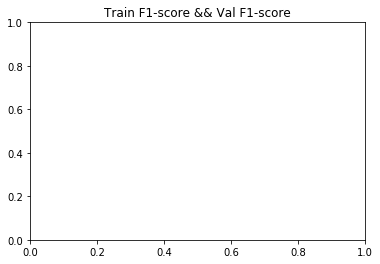

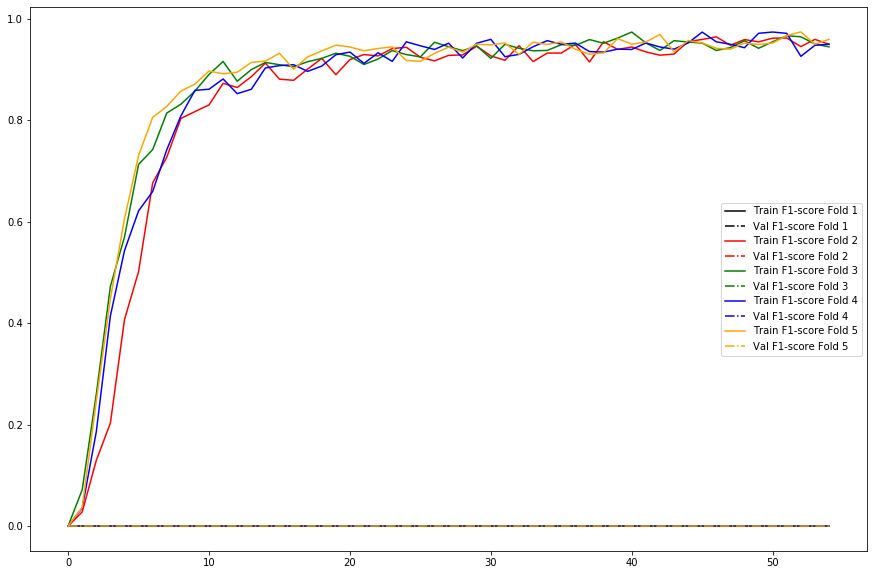

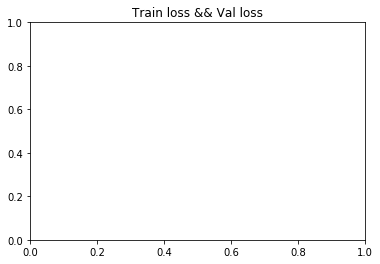

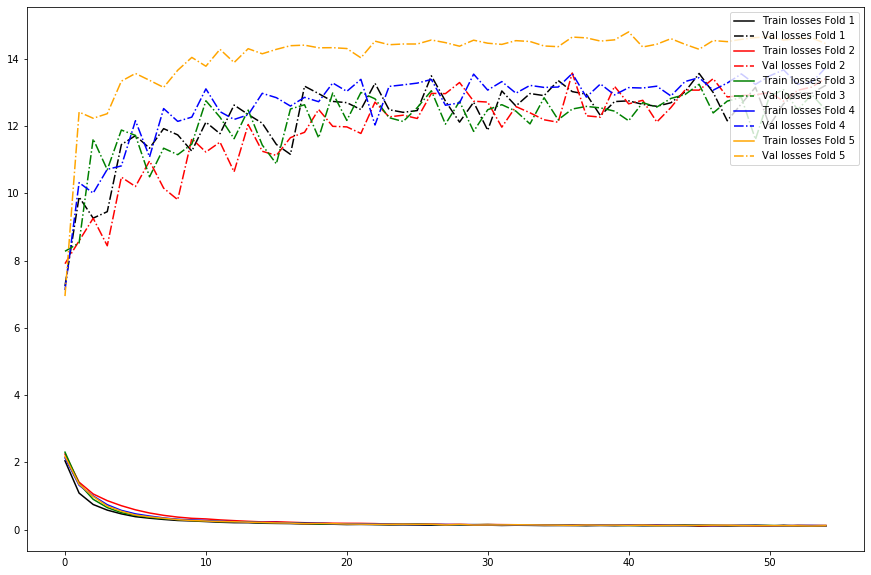

In [0]:
classification.cross_valid(X_train, to_categorical(y_train), 5, 15, 10)

In [0]:
classification.fit_model(X_train, to_categorical(y_train))

Train on 23111 samples, validate on 5778 samples
Epoch 1/3
23111/23111 [==============================] - 2s 93us/step - loss: 2.4957 - f1_score: 0.0118 - val_loss: 1.6105 - val_f1_score: 0.0000e+00
Epoch 2/3
23111/23111 [==============================] - 2s 73us/step - loss: 1.4316 - f1_score: 0.0667 - val_loss: 0.9779 - val_f1_score: 0.4000
Epoch 3/3
23111/23111 [==============================] - 2s 72us/step - loss: 1.0135 - f1_score: 0.2419 - val_loss: 0.7021 - val_f1_score: 0.6250


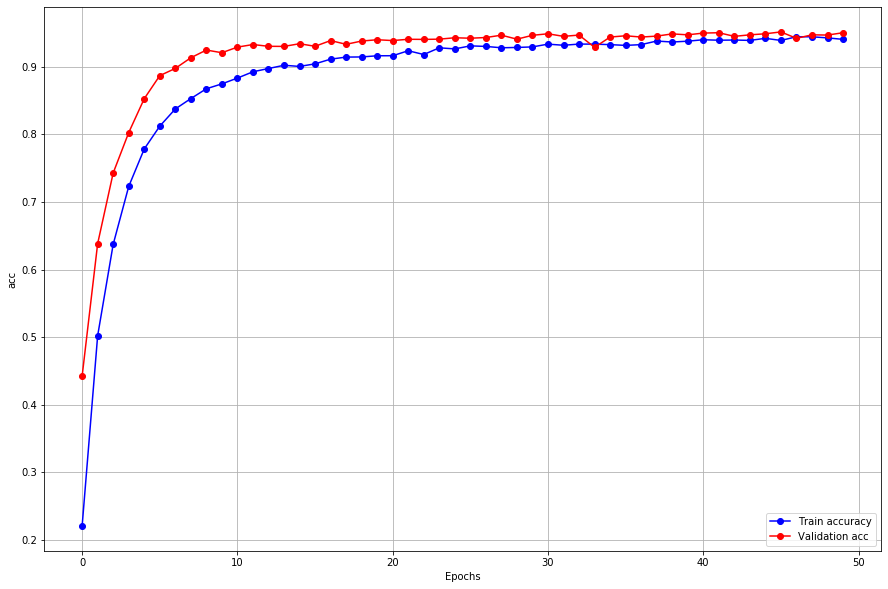

In [0]:
classification.graphic_acc('acc',15,10)

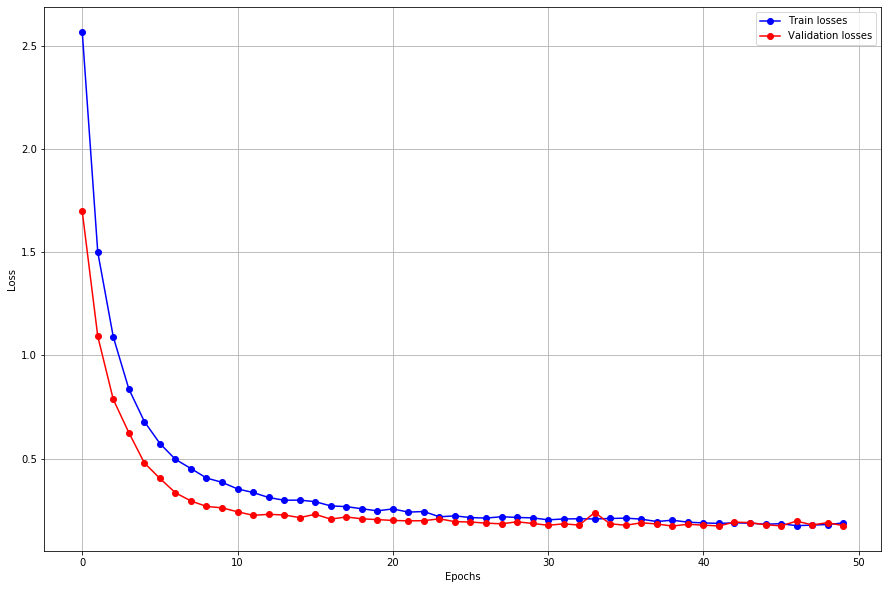

In [0]:
classification.graphic_losses(15,10)

                            precision    recall  f1-score   support

 Ограничение скорости (20)       0.36      0.27      0.30        60
 Ограничение скорости (30)       0.82      0.65      0.72       720
 Ограничение скорости (50)       0.96      0.39      0.55       750
 Ограничение скорости (60)       0.94      0.50      0.66       450
 Ограничение скорости (70)       0.67      0.87      0.76       660
 Ограничение скорости (80)       0.55      0.69      0.61       630
Ограничение скорости (100)       0.41      0.85      0.55       450
Ограничение скорости (120)       0.65      0.55      0.60       450
            Обгон запрещён       0.99      0.96      0.98       480
            Главная дорога       0.95      0.88      0.92       690
           Уступите дорогу       1.00      0.96      0.98       720
                      STOP       1.00      0.99      0.99       270
        Движение запрещено       0.93      1.00      0.96       210
            Въезд запрещён       0.99      0.90

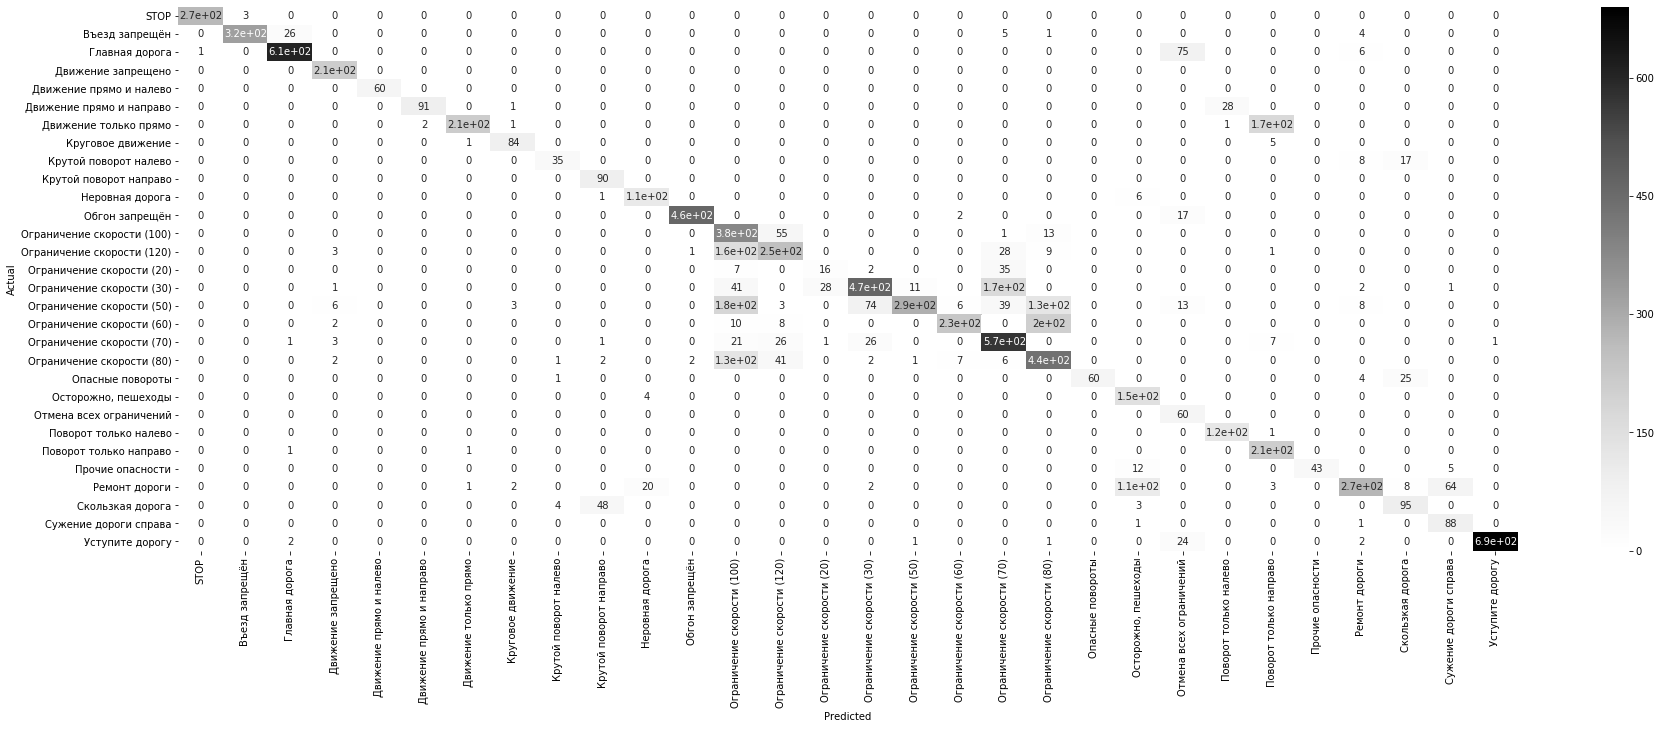

In [0]:
%%time
classification.test_model(X_test, y_test)

In [0]:
X_train_rshp = X_train.reshape(X_train.shape[0], -1)
X_train_rshp, y_train_rshp = shuffle(X_train_rshp, y_train)

In [0]:
X_test_rshp = X_test.reshape(X_test.shape[0], -1)
X_test_rshp, y_test_rshp = shuffle(X_test_rshp, y_test)

                            precision    recall  f1-score   support

 Ограничение скорости (20)       0.08      0.40      0.14        60
 Ограничение скорости (30)       0.32      0.54      0.40       720
 Ограничение скорости (50)       0.34      0.23      0.27       750
 Ограничение скорости (60)       0.30      0.18      0.23       450
 Ограничение скорости (70)       0.58      0.47      0.52       660
 Ограничение скорости (80)       0.20      0.16      0.18       630
Ограничение скорости (100)       0.59      0.35      0.44       450
Ограничение скорости (120)       0.43      0.21      0.28       450
            Обгон запрещён       0.58      0.72      0.64       480
            Главная дорога       0.85      0.69      0.76       690
           Уступите дорогу       0.89      0.96      0.92       720
                      STOP       0.93      0.83      0.88       270
        Движение запрещено       0.40      0.92      0.55       210
            Въезд запрещён       0.97      0.78

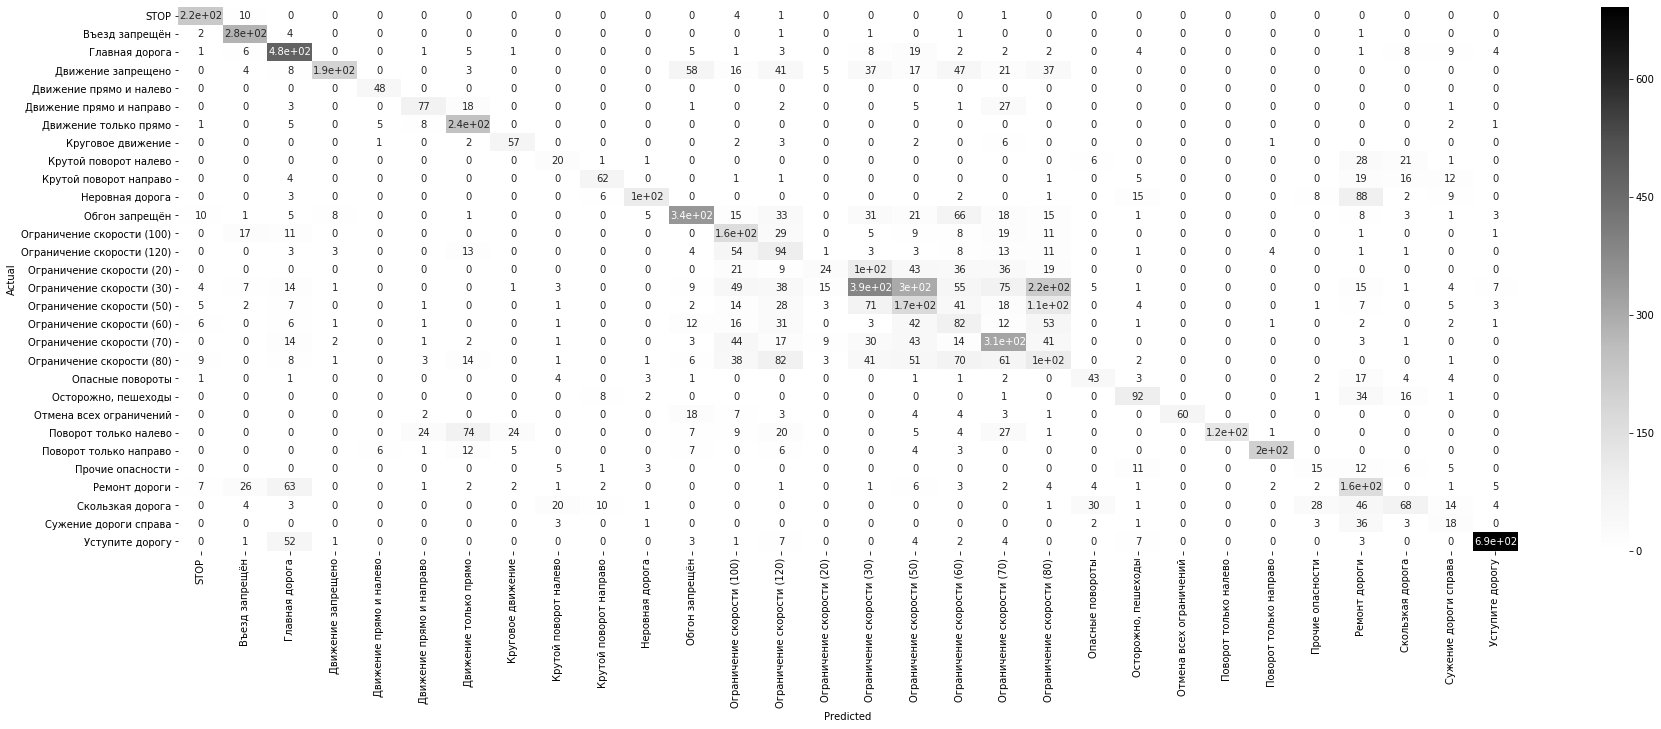

In [0]:
%%time
classification.knn(3, X_train_rshp, y_train_rshp, X_test_rshp, y_test_rshp)

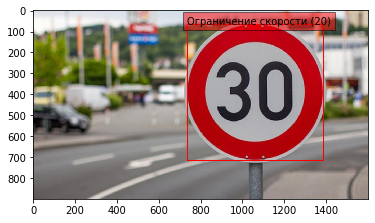

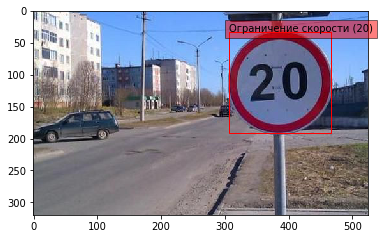

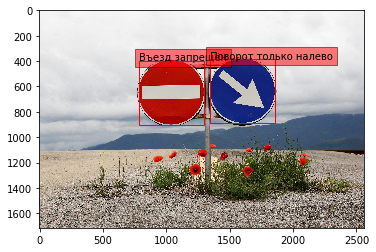

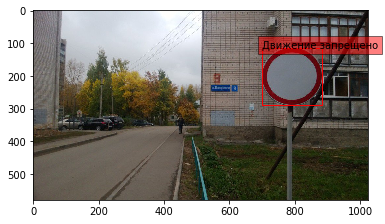

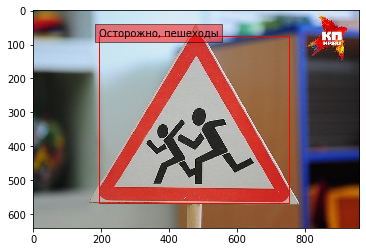

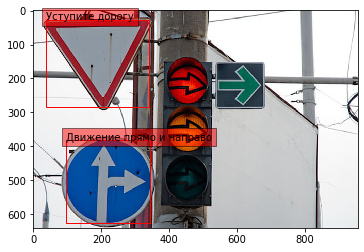

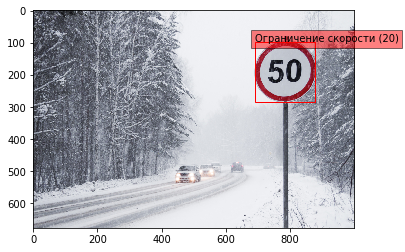

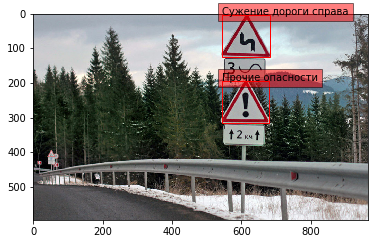

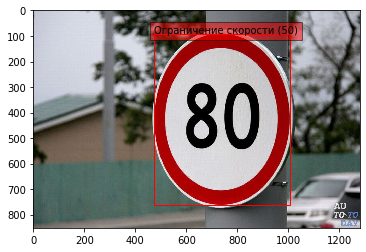

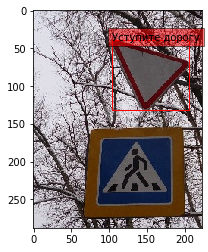

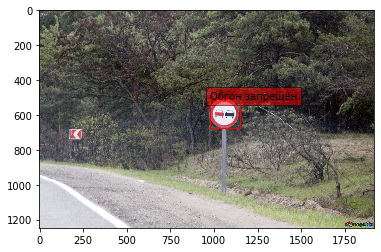

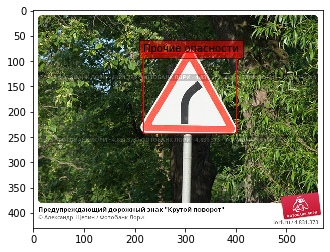

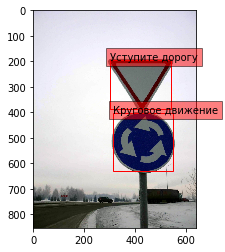

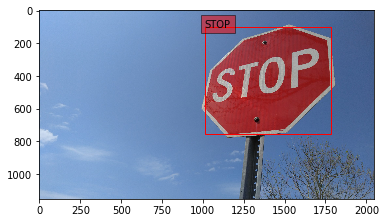

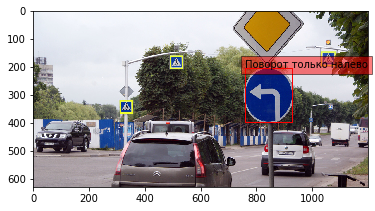

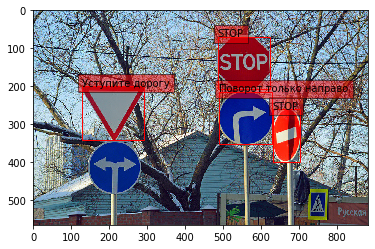

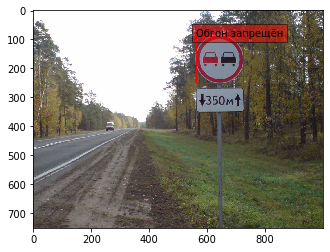

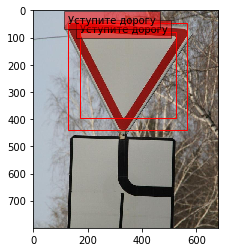

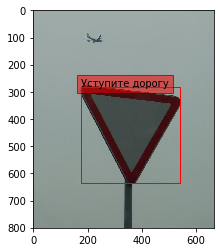

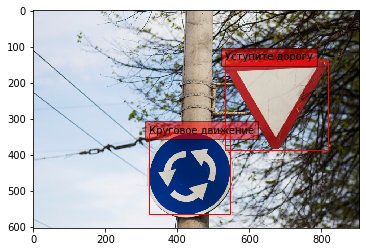

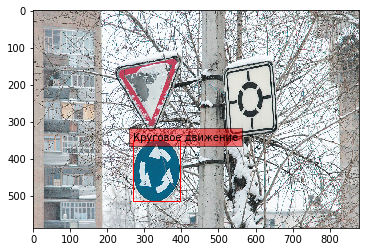

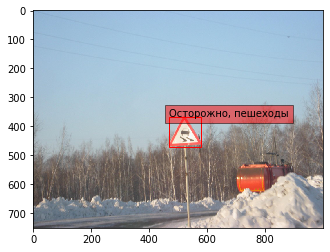

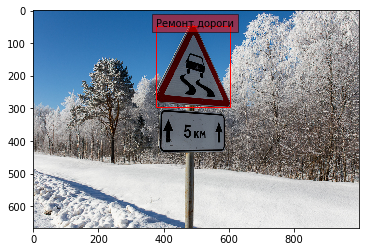

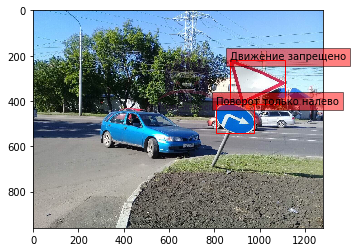

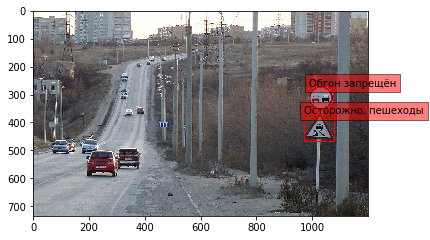

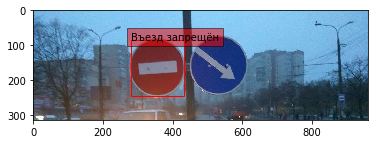

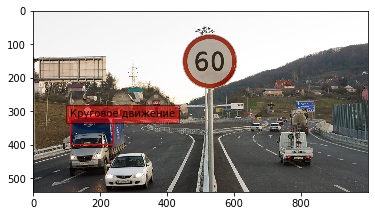

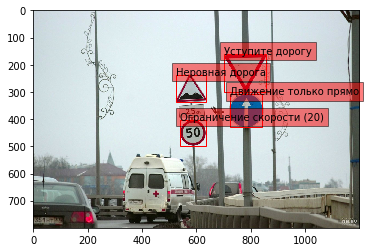

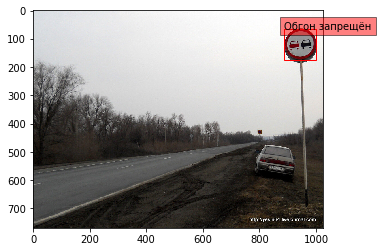

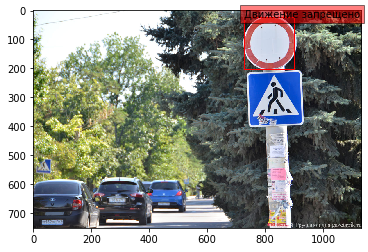

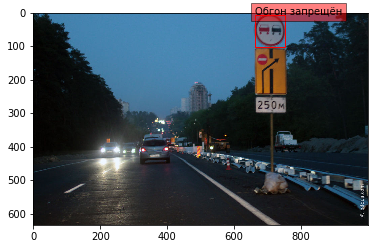

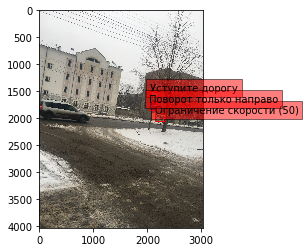

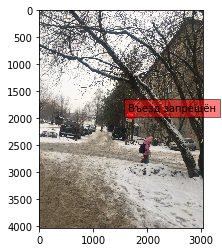

In [0]:
classification.predict_classes_on_images(all_images, rects, images_names)

In [0]:
def show_img_n_hog(grayimg, hogImage):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

  ax1.axis('off')
  ax1.imshow(grayimg)
  ax1.set_title('Input image')

  ax2.axis('off')
  ax2.imshow(hogImage, cmap=plt.cm.gray)
  ax2.set_title('Histogram of Oriented Gradients')
  ax1.set_adjustable('box-forced')
  plt.show()

In [0]:
def rgb2gray(rgb):
  r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
  gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
  return gray

In [0]:
def transform_to_hog(images):
  Hviz = []
  Hfeat = []
  for i in range(0,len(images)):
      I = images[i]
      grayim = rgb2gray(I)
      grayim = transform.resize(grayim,(32,32))

      (H_4x4, hogImage) = feature.hog(grayim, orientations=9, pixels_per_cell=(4, 4),
          cells_per_block=(2, 2), transform_sqrt=True, visualise=True)
      hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255)).astype("uint8")

      Hviz.append(hogImage)
      Hfeat.append(H_4x4)
  
  return np.array(Hfeat).astype("float")

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


[INFO] processed 1000/28889
[INFO] processed 2000/28889


/usr/local/lib/python3.6/dist-packages/skimage/exposure/exposure.py:351: RuntimeWarning: invalid value encountered in true_divide
  image = (image - imin) / float(imax - imin)


[INFO] processed 3000/28889
[INFO] processed 4000/28889
[INFO] processed 5000/28889
[INFO] processed 6000/28889
[INFO] processed 7000/28889
[INFO] processed 8000/28889
[INFO] processed 9000/28889
[INFO] processed 10000/28889
[INFO] processed 11000/28889
[INFO] processed 12000/28889
[INFO] processed 13000/28889
[INFO] processed 14000/28889
[INFO] processed 15000/28889
[INFO] processed 16000/28889
[INFO] processed 17000/28889
[INFO] processed 18000/28889
[INFO] processed 19000/28889
[INFO] processed 20000/28889
[INFO] processed 21000/28889
[INFO] processed 22000/28889
[INFO] processed 23000/28889
[INFO] processed 24000/28889
[INFO] processed 25000/28889
[INFO] processed 26000/28889
[INFO] processed 27000/28889
[INFO] processed 28000/28889


In [0]:
Xhog = transform_to_hog(X_train)

In [0]:
Xhog_test = transform_to_hog(X_test)

In [0]:
y = [5, 4, 3]

In [0]:
label_encoder = LabelEncoder()
label_encoder.fit_transform(y)

array([2, 1, 0])

In [0]:
            # if vratio < self.tol:
            #     if self.verbose >= 1:
            #         print("Converged")
            #     break

In [0]:
%%time
pred = clf.predict(Xhog_test)

CPU times: user 77.5 ms, sys: 34.7 ms, total: 112 ms
Wall time: 35 ms


                            precision    recall  f1-score   support

 Ограничение скорости (20)       0.31      0.93      0.47        60
 Ограничение скорости (30)       0.94      0.23      0.37       720
 Ограничение скорости (50)       0.32      0.95      0.48       750
 Ограничение скорости (60)       0.59      0.78      0.67       450
 Ограничение скорости (70)       0.83      0.60      0.70       660
 Ограничение скорости (80)       0.58      0.23      0.33       630
Ограничение скорости (100)       0.81      0.17      0.28       450
Ограничение скорости (120)       0.49      0.40      0.44       450
            Обгон запрещён       0.89      0.50      0.64       480
            Главная дорога       0.99      0.96      0.98       690
           Уступите дорогу       1.00      0.99      1.00       720
                      STOP       0.97      0.96      0.96       270
        Движение запрещено       0.76      0.99      0.86       210
            Въезд запрещён       1.00      0.86

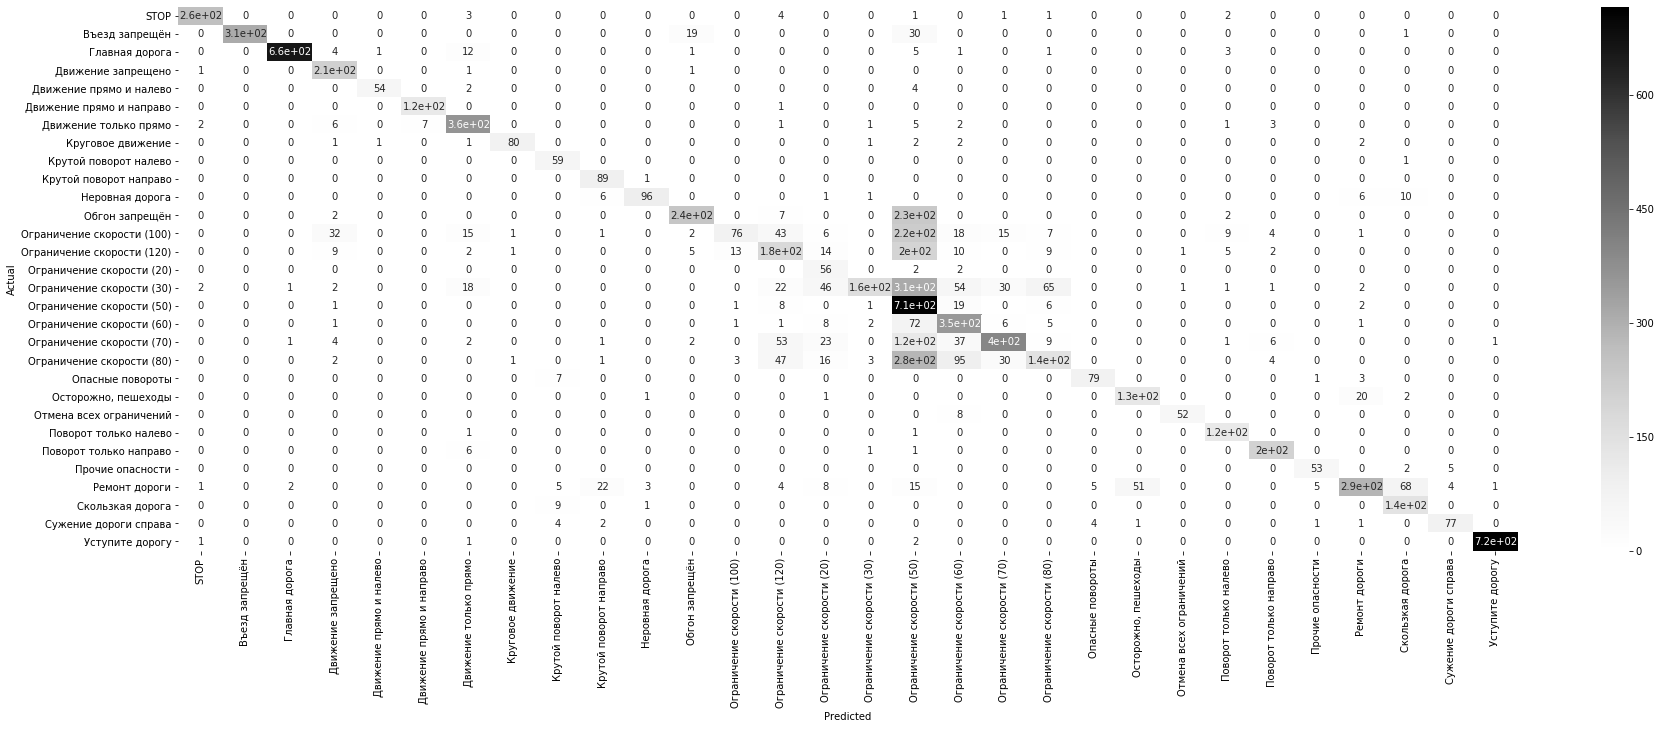

In [0]:
classification.reports(y_test, pred)